In [73]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sqlalchemy import create_engine
from  db_conn import url
import psycopg2
import hvplot.pandas
from path import Path
import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import pickle

In [74]:
postgresInfo = f'postgresql://{url}'
conn_string = postgresInfo

db = create_engine(conn_string)
conn = db.connect()

conn = psycopg2.connect(conn_string)
conn.autocommit = True
cursor = conn.cursor()

In [75]:
df = pd.read_sql_query('''SELECT * FROM players_of_interest ;''', db)
df.head()

,season,name,team,position,games_played,corsi_percentage,fenwick_percentage,goals,points,penalty_minutes,hits,takeaways,giveaways,games_missed,points_per_game
0,2012,Jack Hillen,WSH,D,23,0.49,0.50,3,9,14,10,2,13,0,0.39
1,2012,David Perron,STL,L,48,0.58,0.58,10,25,44,48,26,14,0,0.52
2,2012,Ryane Clowe,NYR,L,40,0.58,0.58,3,19,53,99,13,26,0,0.48
3,2012,Nicklas Grossmann,PHI,D,30,0.41,0.42,1,4,21,81,6,17,18,0.13
4,2012,Vladimir Tarasenko,STL,R,38,0.63,0.63,8,19,10,28,14,6,10,0.50


In [76]:
df.describe

<bound method NDFrame.describe of      season                name team position  games_played  corsi_percentage  \
0      2012         Jack Hillen  WSH        D            23              0.49   
1      2012        David Perron  STL        L            48              0.58   
2      2012         Ryane Clowe  NYR        L            40              0.58   
3      2012   Nicklas Grossmann  PHI        D            30              0.41   
4      2012  Vladimir Tarasenko  STL        R            38              0.63   
..      ...                 ...  ...      ...           ...               ...   
574    2022          Sam Gagner  WPG        C            48              0.57   
575    2022     Mark Borowiecki  NSH        D             4              0.44   
576    2022        Sonny Milano  WSH        L            64              0.52   
577    2022    Nikita Soshnikov  NYI        R             3              0.59   
578    2022  Vladimir Tarasenko  NYR        R            69              0.

In [77]:
print(df.isnull().any())

season                False
name                  False
team                  False
position              False
games_played          False
corsi_percentage      False
fenwick_percentage    False
goals                 False
points                False
penalty_minutes       False
hits                  False
takeaways             False
giveaways             False
games_missed          False
points_per_game       False
dtype: bool


array([[<AxesSubplot:title={'center':'season'}>,
        <AxesSubplot:title={'center':'games_played'}>,
        <AxesSubplot:title={'center':'corsi_percentage'}>],
       [<AxesSubplot:title={'center':'fenwick_percentage'}>,
        <AxesSubplot:title={'center':'goals'}>,
        <AxesSubplot:title={'center':'points'}>],
       [<AxesSubplot:title={'center':'penalty_minutes'}>,
        <AxesSubplot:title={'center':'hits'}>,
        <AxesSubplot:title={'center':'takeaways'}>],
       [<AxesSubplot:title={'center':'giveaways'}>,
        <AxesSubplot:title={'center':'games_missed'}>,
        <AxesSubplot:title={'center':'points_per_game'}>]], dtype=object)

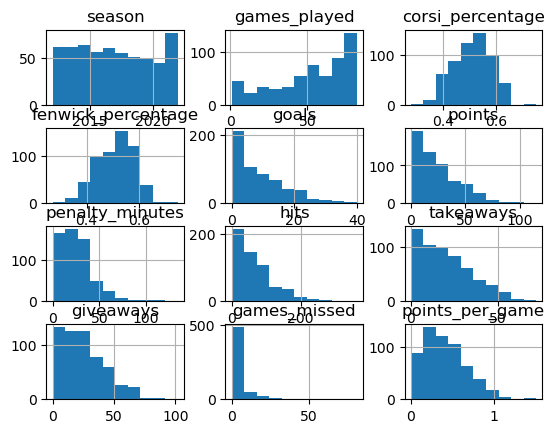

In [78]:
df.hist()

<AxesSubplot:>

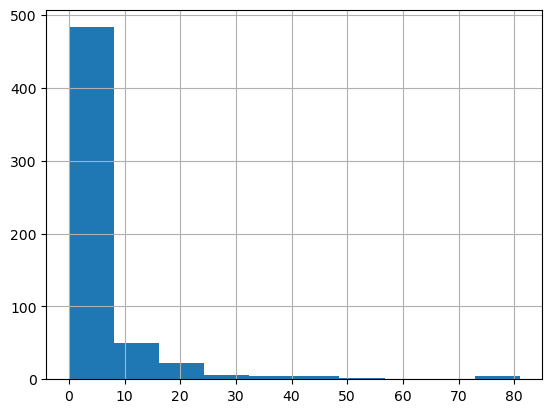

In [79]:
df['games_missed'].hist()

<AxesSubplot:>

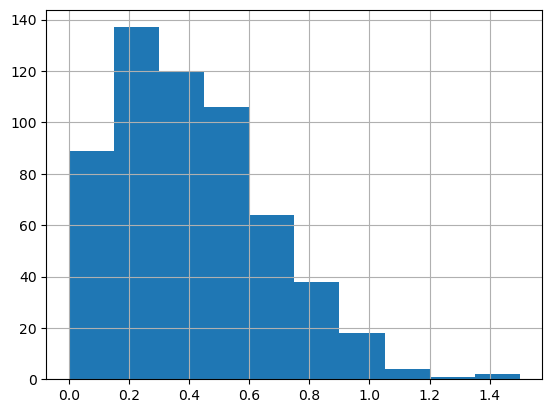

In [80]:
df['points_per_game'].hist()

<AxesSubplot:>

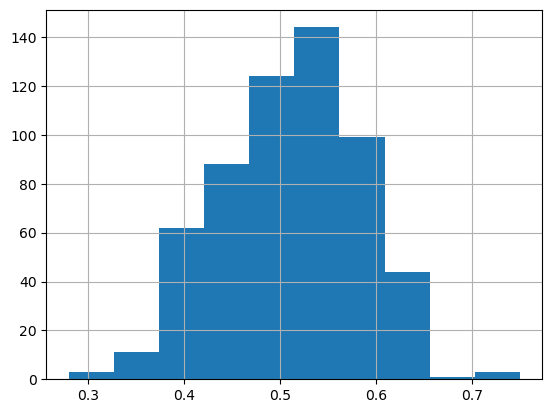

In [81]:
df['corsi_percentage'].hist()

<AxesSubplot:>

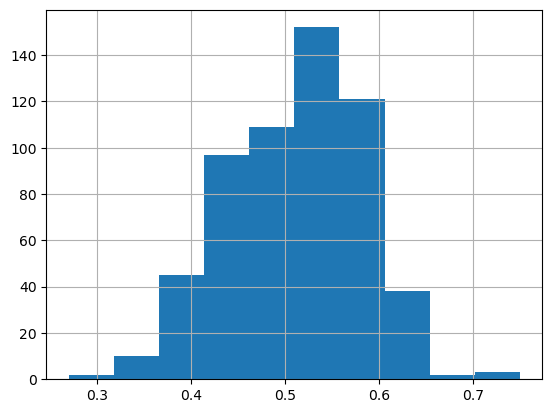

In [82]:
df['fenwick_percentage'].hist()

In [83]:
games_missed = df['games_missed'].value_counts()
print(games_missed)

0     483
10     16
12      9
11      7
14      6
15      6
18      5
16      4
21      4
25      3
20      3
17      3
19      3
42      2
27      2
78      2
13      2
34      2
24      2
44      1
22      1
26      1
62      1
40      1
69      1
35      1
74      1
81      1
80      1
56      1
23      1
46      1
41      1
50      1
Name: games_missed, dtype: int64


In [84]:
df['missed_games_last_season'] = (df['games_missed'].shift(1) > 10).astype(int)
previous_season_missed = df[df['missed_games_last_season'] == 1]
previous_season_not_missed = df[df['missed_games_last_season'] == 0]
previous_season_missed_mean = previous_season_missed.mean()
previous_season_not_missed_mean = previous_season_not_missed.mean()

/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.

/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



In [85]:
difference = previous_season_missed_mean - previous_season_not_missed_mean
print(difference)

season                      0.067034
games_played                2.058567
corsi_percentage            0.008647
fenwick_percentage          0.011804
goals                       2.084895
points                      5.195291
penalty_minutes            -0.793612
hits                       -0.850927
takeaways                   1.745516
giveaways                   0.938727
games_missed                0.407565
points_per_game             0.063292
missed_games_last_season    1.000000
dtype: float64


In [86]:
# Filter dataframe to include only players who missed 10 or more games in the previous season
prev_season = df[df["games_missed"].shift(1) >= 10]

# Print unique values of "name" column in filtered dataframe
print(prev_season["name"].unique())

['Vladimir Tarasenko' 'Trevor Lewis' 'Jordan Staal' 'John Moore'
 'Peter Holland' 'Simon Despres' 'David Perron' 'Andrew Shaw'
 'Tyler Bozak' 'Jack Hillen' 'Marcus Johansson' 'Ales Hemsky' 'Saku Koivu'
 'Travis Hamonic' 'George Parros' 'Jakub Voracek' 'Justin Falk'
 'Carl Gunnarsson' 'Lubomir Visnovsky' 'Jonathan Huberdeau'
 'Phillip Danault' 'Marc Staal' 'Keith Ballard' 'Raphael Diaz'
 'Loui Eriksson' 'Korbinian Holzer' 'Ryane Clowe' 'Leo Komarov'
 'Sonny Milano' 'Connor Murphy' 'Micheal Ferland' 'Radko Gudas'
 'Sami Vatanen' 'Patrick Sharp' 'David Warsofsky' 'Jonathan Toews'
 'Roman Josi' 'Ondrej Kase' 'Scott Laughton' 'Brandon Pirri'
 'Mathieu Perreault' 'Nikita Soshnikov' 'Teuvo Teravainen' 'Matt Hunwick'
 'Charlie McAvoy' 'Patric Hornqvist' 'J.T. Compher' 'Jake Muzzin'
 'Scott Sabourin' 'Trevor Moore' 'Alec Martinez']


In [87]:
filtered_df = df[df['games_missed'] >= 10]

filtered_df.head()

,season,name,team,position,games_played,corsi_percentage,fenwick_percentage,goals,points,penalty_minutes,hits,takeaways,giveaways,games_missed,points_per_game,missed_games_last_season
3,2012,Nicklas Grossmann,PHI,D,30,0.41,0.42,1,4,21,81,6,17,18,0.13,0
4,2012,Vladimir Tarasenko,STL,R,38,0.63,0.63,8,19,10,28,14,6,10,0.50,1
9,2012,Eric Selleck,FLA,L,2,0.44,0.48,0,1,7,5,2,0,16,0.50,0
20,2012,Chad LaRose,CAR,R,35,0.54,0.54,2,4,19,59,8,6,10,0.11,0
31,2012,Rene Bourque,MTL,R,27,0.55,0.55,7,13,22,37,8,6,21,0.48,0


In [88]:
new_df = df.loc[df['games_missed'] >= 5, ['season', 'name', 'games_played', 'corsi_percentage', 'fenwick_percentage', 'games_missed', 'points_per_game']]
new_df.head(20)

,season,name,games_played,corsi_percentage,fenwick_percentage,games_missed,points_per_game
3,2012,Nicklas Grossmann,30,0.41,0.42,18,0.13
4,2012,Vladimir Tarasenko,38,0.63,0.63,10,0.50
9,2012,Eric Selleck,2,0.44,0.48,16,0.50
20,2012,Chad LaRose,35,0.54,0.54,10,0.11
31,2012,Rene Bourque,27,0.55,0.55,21,0.48
56,2012,Raphael Diaz,23,0.51,0.54,25,0.61
60,2012,Daniel Briere,34,0.54,0.52,10,0.47
65,2013,Roman Josi,72,0.49,0.51,10,0.56
68,2013,Jonathan Huberdeau,69,0.56,0.54,11,0.41
76,2013,Tomas Kopecky,49,0.49,0.49,24,0.24


In [89]:
new_df.describe

<bound method NDFrame.describe of      season                name  games_played  corsi_percentage  \
3      2012   Nicklas Grossmann            30              0.41   
4      2012  Vladimir Tarasenko            38              0.63   
9      2012        Eric Selleck             2              0.44   
20     2012         Chad LaRose            35              0.54   
31     2012        Rene Bourque            27              0.55   
..      ...                 ...           ...               ...   
549    2022         Radko Gudas            72              0.49   
554    2022    Patric Hornqvist            22              0.63   
557    2022      Travis Dermott            11              0.40   
562    2022         Ondrej Kase             1              0.74   
569    2022       Jakub Voracek            11              0.50   

     fenwick_percentage  games_missed  points_per_game  
3                  0.42            18             0.13  
4                  0.63            10          

In [90]:
# Create a new column for the next season
new_df['next_season'] = new_df['season'] + 1

# Merge the original dataframe with itself based on the name and the next season
merged_df = pd.merge(new_df, new_df[['name', 'season', 'points_per_game']], left_on=['name', 'next_season'], right_on=['name', 'season'], suffixes=('', '_next'))

# Select the desired columns
result_df = merged_df[['season', 'name', 'games_played', 'corsi_percentage', 'fenwick_percentage', 'games_missed', 'points_per_game', 'points_per_game_next']]

In [91]:
result_df.head(20)

,season,name,games_played,corsi_percentage,fenwick_percentage,games_missed,points_per_game,points_per_game_next
0,2012,Daniel Briere,34,0.54,0.52,10,0.47,0.36
1,2014,Clarke MacArthur,62,0.57,0.54,18,0.58,0.00
2,2014,Johan Franzen,33,0.61,0.59,42,0.67,0.50
3,2015,Clarke MacArthur,4,0.58,0.57,78,0.00,0.00
4,2017,Ondrej Kase,66,0.56,0.55,10,0.58,0.67
5,2018,Drake Caggiula,55,0.49,0.48,13,0.42,0.38
6,2019,Andrew Shaw,26,0.56,0.54,44,0.38,0.29
7,2021,Ondrej Kase,50,0.51,0.50,20,0.54,0.00


In [92]:
df1 = pd.read_csv("../Resources/Players_of_Interest.csv")
df1.head()

,season,name,team,position,games_played,corsi_percentage,fenwick_percentage,goals,points,penalty_minutes,hits,takeaways,giveaways,games_missed,points_per_game
0,2012,Jack Hillen,WSH,D,23,0.49,0.50,3,9,14,10,2,13,0,0.39
1,2012,David Perron,STL,L,48,0.58,0.58,10,25,44,48,26,14,0,0.52
2,2012,Ryane Clowe,NYR,L,40,0.58,0.58,3,19,53,99,13,26,0,0.48
3,2012,Nicklas Grossmann,PHI,D,30,0.41,0.42,1,4,21,81,6,17,18,0.13
4,2012,Vladimir Tarasenko,STL,R,38,0.63,0.63,8,19,10,28,14,6,10,0.50


In [93]:
#sort dataset by name and season
df1 = df1.sort_values(['name', 'season'])

#add columns for PPGP and PPGN
df1['PPGP'] = 0.0
df1['PPGN'] = 0.0

#loop through each player in dataset
for player in df1['name'].unique():
    #get indices of rows for this player
    player_indices = df1.index[df1['name'] == player]
    
    #loop through each row for this player
    for i in range(len(player_indices)):
        #get the index of the previous season row
        prev_index = player_indices[i] - 1
        
        #if previous season row exists and player missed more than 5 games in the current row
        if prev_index >= 0 and df1.loc[player_indices[i], 'games_missed'] > 5:
            #set PPGP to the points per game of the previous season row
            df1.loc[player_indices[i], 'PPGP'] = df1.loc[prev_index, 'points_per_game']
        
        #get index of the next season row
        next_index = player_indices[i] + 1
        
        #if next season row exists and the player missed more than 5 games in the current row
        if next_index < len(df1.index) and df1.loc[player_indices[i], 'games_missed'] > 5:
            #set PPGN to points per game of the next season row
            df1.loc[player_indices[i], 'PPGN'] = df1.loc[next_index, 'points_per_game']



In [94]:
df1.head(10)

,season,name,team,position,games_played,corsi_percentage,fenwick_percentage,goals,points,penalty_minutes,hits,takeaways,giveaways,games_missed,points_per_game,PPGP,PPGN
17,2012,Alec Martinez,L.A,D,27,0.60,0.59,1,5,10,31,2,13,0,0.19,0.00,0.00
101,2013,Alec Martinez,L.A,D,61,0.61,0.61,11,22,14,96,5,27,0,0.36,0.00,0.00
129,2014,Alec Martinez,L.A,D,56,0.53,0.53,6,22,10,95,11,38,18,0.39,0.16,0.46
188,2015,Alec Martinez,L.A,D,78,0.52,0.52,10,31,40,164,8,60,0,0.40,0.00,0.00
301,2016,Alec Martinez,L.A,D,82,0.54,0.55,9,39,24,137,5,51,0,0.48,0.00,0.00
308,2017,Alec Martinez,L.A,D,77,0.47,0.47,9,25,34,100,11,81,0,0.32,0.00,0.00
371,2018,Alec Martinez,L.A,D,60,0.47,0.47,4,18,8,78,12,70,0,0.30,0.00,0.00
451,2019,Alec Martinez,VGK,D,51,0.50,0.51,3,17,23,43,14,32,0,0.33,0.00,0.00
458,2020,Alec Martinez,VGK,D,53,0.49,0.51,9,31,12,44,12,26,0,0.58,0.00,0.00
541,2021,Alec Martinez,VGK,D,26,0.50,0.51,3,8,4,26,8,19,0,0.31,0.00,0.00


In [95]:
df2 = pd.read_csv('../Resources/Players_of_Interest.csv')

new_df = pd.DataFrame(columns=['season', 'name', 'team', 'position', 'games_played', 'corsi_percentage', 'fenwick_percentage', 'goals', 'points', 'penalty_minutes', 'hits', 'takeaways', 'giveaways', 'games_missed', 'points_per_game', 'PPGP', 'PPGN'])

for i in range(len(df2)):
    #check if player missed more than 5 games in a season
    if df2.iloc[i]['games_missed'] > 5:
        name = df2.iloc[i]['name']
        season = df2.iloc[i]['season']
        #get previous season's points per game
        prev_ppg = df2.loc[(df2['name'] == name) & (df2['season'] == season-1), 'points_per_game'].values
        if len(prev_ppg) == 0:
            prev_ppg = None
        else:
            prev_ppg = prev_ppg[0]
        #get next season's points per game
        next_ppg = df2.loc[(df2['name'] == name) & (df2['season'] == season+1), 'points_per_game'].values
        if len(next_ppg) == 0:
            next_ppg = None
        else:
            next_ppg = next_ppg[0]
        #add new row to dataframe
        new_df = new_df.append({
            'season': df2.iloc[i]['season'],
            'name': df2.iloc[i]['name'],
            'team': df2.iloc[i]['team'],
            'position': df2.iloc[i]['position'],
            'games_played': df2.iloc[i]['games_played'],
            'corsi_percentage': df2.iloc[i]['corsi_percentage'],
            'fenwick_percentage': df2.iloc[i]['fenwick_percentage'],
            'goals': df2.iloc[i]['goals'],
            'points': df2.iloc[i]['points'],
            'penalty_minutes': df2.iloc[i]['penalty_minutes'],
            'hits': df2.iloc[i]['hits'],
            'takeaways': df2.iloc[i]['takeaways'],
            'giveaways': df2.iloc[i]['giveaways'],
            'games_missed': df2.iloc[i]['games_missed'],
            'points_per_game': df2.iloc[i]['points_per_game'],
            'PPGP': prev_ppg,
            'PPGN': next_ppg
        }, ignore_index=True)

In [96]:
new_df

,season,name,team,position,games_played,corsi_percentage,fenwick_percentage,goals,points,penalty_minutes,hits,takeaways,giveaways,games_missed,points_per_game,PPGP,PPGN
0,2012,Nicklas Grossmann,PHI,D,30,0.41,0.42,1,4,21,81,6,17,18,0.13,NaN,0.18
1,2012,Vladimir Tarasenko,STL,R,38,0.63,0.63,8,19,10,28,14,6,10,0.50,NaN,0.67
2,2012,Eric Selleck,FLA,L,2,0.44,0.48,0,1,7,5,2,0,16,0.50,NaN,None
3,2012,Chad LaRose,CAR,R,35,0.54,0.54,2,4,19,59,8,6,10,0.11,NaN,None
4,2012,Rene Bourque,MTL,R,27,0.55,0.55,7,13,22,37,8,6,21,0.48,NaN,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2022,Radko Gudas,FLA,D,72,0.49,0.49,2,17,79,312,20,36,10,0.24,0.21,None
92,2022,Patric Hornqvist,FLA,R,22,0.63,0.62,1,3,13,18,5,0,40,0.14,0.43,None
93,2022,Travis Dermott,VAN,D,11,0.40,0.40,1,1,2,10,1,1,34,0.09,0.12,None
94,2022,Ondrej Kase,CAR,R,1,0.74,0.72,0,0,0,1,1,0,62,0.00,0.54,None


In [97]:
new_df = new_df.dropna(subset=['PPGP', 'PPGN'])
new_df

,season,name,team,position,games_played,corsi_percentage,fenwick_percentage,goals,points,penalty_minutes,hits,takeaways,giveaways,games_missed,points_per_game,PPGP,PPGN
7,2013,Roman Josi,NSH,D,72,0.49,0.51,13,40,18,32,22,34,10,0.56,0.38,0.68
8,2013,Jonathan Huberdeau,FLA,L,69,0.56,0.54,9,28,37,73,32,21,11,0.41,0.65,0.68
9,2013,Tomas Kopecky,FLA,R,49,0.49,0.49,4,12,18,31,17,10,24,0.24,0.57,0.12
10,2013,Alexander Semin,CAR,R,65,0.60,0.59,22,42,42,22,49,56,12,0.65,1.0,0.33
12,2013,Loui Eriksson,BOS,L,61,0.59,0.58,10,37,6,12,31,17,15,0.61,0.6,0.58
14,2013,Travis Hamonic,NYI,D,69,0.47,0.47,3,18,48,93,40,51,12,0.26,0.21,0.46
15,2013,Marc Staal,NYR,D,72,0.51,0.50,3,14,24,83,41,48,10,0.19,0.52,0.25
16,2013,Daniel Briere,MTL,C,69,0.52,0.52,13,25,30,23,22,17,10,0.36,0.47,0.21
19,2013,Tim Gleason,TOR,D,56,0.39,0.38,1,6,55,156,9,26,10,0.11,0.21,0.12
21,2013,Lubomir Visnovsky,NYI,D,24,0.61,0.59,3,11,10,14,15,18,12,0.46,0.4,0.38


In [98]:
new_df.to_csv('../Resources/ML_player_dataset.csv', index=False)

In [99]:
ML_names = new_df.filter(['name', 'team', 'position'], axis = 1)
ML_names.head()

,name,team,position
7,Roman Josi,NSH,D
8,Jonathan Huberdeau,FLA,L
9,Tomas Kopecky,FLA,R
10,Alexander Semin,CAR,R
12,Loui Eriksson,BOS,L


In [100]:
del new_df['name'], new_df['team'], new_df['position']


In [101]:
new_df

,season,games_played,corsi_percentage,fenwick_percentage,goals,points,penalty_minutes,hits,takeaways,giveaways,games_missed,points_per_game,PPGP,PPGN
7,2013,72,0.49,0.51,13,40,18,32,22,34,10,0.56,0.38,0.68
8,2013,69,0.56,0.54,9,28,37,73,32,21,11,0.41,0.65,0.68
9,2013,49,0.49,0.49,4,12,18,31,17,10,24,0.24,0.57,0.12
10,2013,65,0.60,0.59,22,42,42,22,49,56,12,0.65,1.0,0.33
12,2013,61,0.59,0.58,10,37,6,12,31,17,15,0.61,0.6,0.58
14,2013,69,0.47,0.47,3,18,48,93,40,51,12,0.26,0.21,0.46
15,2013,72,0.51,0.50,3,14,24,83,41,48,10,0.19,0.52,0.25
16,2013,69,0.52,0.52,13,25,30,23,22,17,10,0.36,0.47,0.21
19,2013,56,0.39,0.38,1,6,55,156,9,26,10,0.11,0.21,0.12
21,2013,24,0.61,0.59,3,11,10,14,15,18,12,0.46,0.4,0.38


In [102]:
X = pd.get_dummies(new_df, columns=["points_per_game", "PPGP", "PPGN"])
X

,season,games_played,corsi_percentage,fenwick_percentage,goals,points,penalty_minutes,hits,takeaways,giveaways,...,PPGN_0.58,PPGN_0.62,PPGN_0.64,PPGN_0.67,PPGN_0.68,PPGN_0.69,PPGN_0.7,PPGN_0.71,PPGN_0.83,PPGN_0.84
7,2013,72,0.49,0.51,13,40,18,32,22,34,...,0,0,0,0,1,0,0,0,0,0
8,2013,69,0.56,0.54,9,28,37,73,32,21,...,0,0,0,0,1,0,0,0,0,0
9,2013,49,0.49,0.49,4,12,18,31,17,10,...,0,0,0,0,0,0,0,0,0,0
10,2013,65,0.60,0.59,22,42,42,22,49,56,...,0,0,0,0,0,0,0,0,0,0
12,2013,61,0.59,0.58,10,37,6,12,31,17,...,1,0,0,0,0,0,0,0,0,0
14,2013,69,0.47,0.47,3,18,48,93,40,51,...,0,0,0,0,0,0,0,0,0,0
15,2013,72,0.51,0.50,3,14,24,83,41,48,...,0,0,0,0,0,0,0,0,0,0
16,2013,69,0.52,0.52,13,25,30,23,22,17,...,0,0,0,0,0,0,0,0,0,0
19,2013,56,0.39,0.38,1,6,55,156,9,26,...,0,0,0,0,0,0,0,0,0,0
21,2013,24,0.61,0.59,3,11,10,14,15,18,...,0,0,0,0,0,0,0,0,0,0


In [103]:
# X_scaled = MinMaxScaler().fit_transform(X)
# X_scaled
X_scaled = StandardScaler().fit_transform(X)
X_scaled

array([[-1.33018335,  1.35057576, -0.50926053, ..., -0.13130643,
        -0.13130643, -0.13130643],
       [-1.33018335,  1.17231185,  0.58618009, ..., -0.13130643,
        -0.13130643, -0.13130643],
       [-1.33018335, -0.01611425, -0.50926053, ..., -0.13130643,
        -0.13130643, -0.13130643],
       ...,
       [ 1.74749578,  0.39983488, -0.97873508, ..., -0.13130643,
        -0.13130643, -0.13130643],
       [ 1.74749578, -0.13495686, -0.66575205, ..., -0.13130643,
        -0.13130643, -0.13130643],
       [ 1.74749578,  1.05346924, -1.1352266 , ..., -0.13130643,
        -0.13130643, -0.13130643]])

In [104]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)
X_pca

array([[ 2.82456629, -0.22016589, -1.82758391],
       [ 2.42157952, -0.75690869, -2.28936652],
       [-1.70094156,  1.63249564, -2.51390974],
       [ 5.3276624 , -3.59558394, -2.29104141],
       [ 0.69427982, -3.72909718, -3.28898266],
       [ 2.83637054,  2.56097897, -2.59742123],
       [ 2.28458545,  1.4009303 , -3.0201485 ],
       [ 1.43480989, -0.94002163, -3.57244921],
       [ 0.4348446 ,  5.18002977, -2.67157751],
       [-2.373377  , -2.14696783, -1.30997806],
       [-3.02322237, -2.39035744, -0.77497521],
       [ 0.182498  , -0.15139839, -0.86852516],
       [-0.40151631, -2.67948751, -2.36458457],
       [ 2.09356711,  0.42698513, -1.88947847],
       [-1.11806253,  2.265878  , -3.37886683],
       [ 1.63237976, -1.98774984,  0.61824153],
       [ 0.69815536, -1.82229694, -0.72605251],
       [-2.80283353, -2.70569127,  1.35985587],
       [-0.53327675, -0.53527636, -1.1744123 ],
       [ 2.49156343, -3.06169785,  0.0889518 ],
       [ 1.00298251, -1.83523778, -0.569

In [105]:
pcs_df=pd.DataFrame(
data=X_pca, columns=["PC 1", "PC 2", "PC 3"], index = new_df.index)
pcs_df.head(10)

,PC 1,PC 2,PC 3
7,2.824566,-0.220166,-1.827584
8,2.421580,-0.756909,-2.289367
9,-1.700942,1.632496,-2.513910
10,5.327662,-3.595584,-2.291041
12,0.694280,-3.729097,-3.288983
14,2.836371,2.560979,-2.597421
15,2.284585,1.400930,-3.020149
16,1.434810,-0.940022,-3.572449
19,0.434845,5.180030,-2.671578
21,-2.373377,-2.146968,-1.309978


In [106]:
pcs_df.dtypes

PC 1    float64
PC 2    float64
PC 3    float64
dtype: object

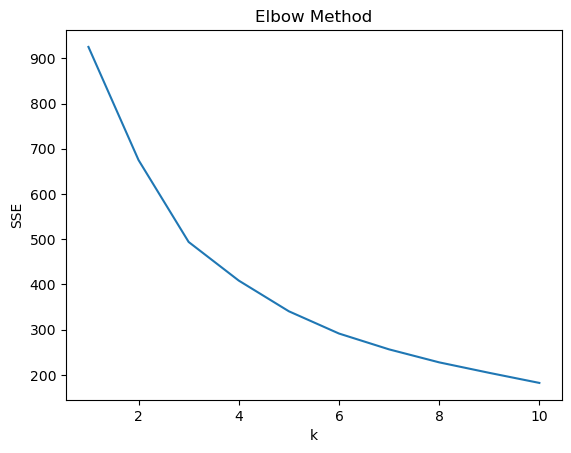

In [107]:
inertia = {}
k = list(range(1, 11))
for i in k:
   km = KMeans(n_clusters=i)
   km.fit(pcs_df)
   inertia[i]= km.inertia_

# Plot
plt.plot(list(inertia.keys()), list(inertia.values()))
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('Elbow Method')
plt.show()

In [108]:
model = KMeans(n_clusters=6, random_state=42)
model.fit(pcs_df)
predictions = model.predict(pcs_df)
predictions


array([0, 0, 4, 5, 2, 0, 0, 0, 4, 1, 1, 2, 2, 0, 4, 2, 2, 1, 2, 2, 2, 4,
       4, 1, 4, 0, 2, 2, 2, 2, 3, 2, 4, 3, 1, 1, 5, 2, 3, 5, 3, 2, 2, 1,
       3, 3, 2, 4, 3, 1, 3, 1, 1, 2, 3, 2, 3, 3, 3], dtype=int32)

In [109]:
with open ('model.pkl', 'wb') as f: 
    pickle.dump(model,f)

In [110]:
with open ('model.pkl', 'rb') as f:
  mp = pickle.load(f)


In [111]:
mp.n_features_in_

3

In [112]:

d = {'PC 1': [1], 'PC 2': [1] , 'PC 3' : [1]}
df = pd.DataFrame(data=d)
df

,PC 1,PC 2,PC 3
0,1,1,1


In [113]:
input_x = np.array([1,1,1])
input_x

array([1, 1, 1])

In [114]:
type(input_x)

numpy.ndarray

In [115]:
input_x_1 = input_x.reshape(1, -1)
input_x_1
# array.reshape(1, -1)

array([[1, 1, 1]])

In [116]:
predictions_test = mp.predict(df)

In [117]:
predictions_test

array([3], dtype=int32)

In [118]:
clustered_df = pd.concat([new_df, pcs_df], axis = 1)
clustered_df["name"]= ML_names["name"]
clustered_df["position"] = ML_names["position"]
clustered_df["team"] = ML_names["team"]
clustered_df["class"] = predictions
clustered_df.head(10) 

,season,games_played,corsi_percentage,fenwick_percentage,goals,points,penalty_minutes,hits,takeaways,giveaways,...,points_per_game,PPGP,PPGN,PC 1,PC 2,PC 3,name,position,team,class
7,2013,72,0.49,0.51,13,40,18,32,22,34,...,0.56,0.38,0.68,2.824566,-0.220166,-1.827584,Roman Josi,D,NSH,0
8,2013,69,0.56,0.54,9,28,37,73,32,21,...,0.41,0.65,0.68,2.421580,-0.756909,-2.289367,Jonathan Huberdeau,L,FLA,0
9,2013,49,0.49,0.49,4,12,18,31,17,10,...,0.24,0.57,0.12,-1.700942,1.632496,-2.513910,Tomas Kopecky,R,FLA,4
10,2013,65,0.60,0.59,22,42,42,22,49,56,...,0.65,1.0,0.33,5.327662,-3.595584,-2.291041,Alexander Semin,R,CAR,5
12,2013,61,0.59,0.58,10,37,6,12,31,17,...,0.61,0.6,0.58,0.694280,-3.729097,-3.288983,Loui Eriksson,L,BOS,2
14,2013,69,0.47,0.47,3,18,48,93,40,51,...,0.26,0.21,0.46,2.836371,2.560979,-2.597421,Travis Hamonic,D,NYI,0
15,2013,72,0.51,0.50,3,14,24,83,41,48,...,0.19,0.52,0.25,2.284585,1.400930,-3.020149,Marc Staal,D,NYR,0
16,2013,69,0.52,0.52,13,25,30,23,22,17,...,0.36,0.47,0.21,1.434810,-0.940022,-3.572449,Daniel Briere,C,MTL,0
19,2013,56,0.39,0.38,1,6,55,156,9,26,...,0.11,0.21,0.12,0.434845,5.180030,-2.671578,Tim Gleason,D,TOR,4
21,2013,24,0.61,0.59,3,11,10,14,15,18,...,0.46,0.4,0.38,-2.373377,-2.146968,-1.309978,Lubomir Visnovsky,D,NYI,1


<AxesSubplot:title={'center':'season'}, xlabel='[class]'>

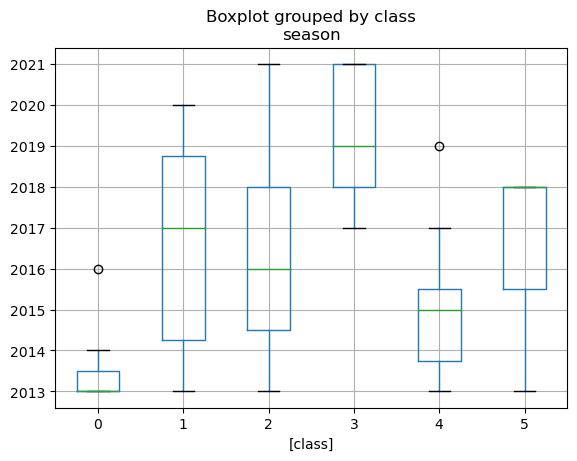

In [119]:
clustered_df.boxplot(['season'], by=['class'])

In [120]:
fig = px.scatter_3d(
    clustered_df,
    x="PC 1",
    y="PC 2",
    z="PC 3",
    color="class",
    symbol="class",
    width=800,
    hover_name="name",
    hover_data=["games_missed"],
)
fig.update_layout(legend=dict(x=0, y=1))
fig.show()